# Contributions to changing labor force participation

Brian Dew

March 4, 2018

In [1]:
# Import preliminaries and connect to CPS database
import pandas as pd
import numpy as np
import itertools

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

In [2]:
# Parameters
age = (25, 54)
sex = ('Total', [1, 2])

In [3]:
# Demographic master file
y = 2001   # Base year
df = pd.read_feather(f'data/cps_{y}.ft', nthreads=3)
df = df[(df['PRTAGE'].between(16, 80)) & (df['HRMONTH'] == 3)]
df['age_sex'] = df['PRTAGE'].astype('str') + df['PESEX'].astype('str')
age_sex = (df.groupby('age_sex')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()

d = {}
for y in list(range(2000, 2019)):
    df = pd.read_feather(f'data/cps_{y}.ft', nthreads=3)
    df['age_sex'] = df['PRTAGE'].astype('str') + df['PESEX'].astype('str')
    for i, df in df.groupby('HRMONTH'):
        d1 = (df.groupby('age_sex')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        d[f'{y}-{i}_age_sex'] = {k: float(age_sex[k])/d1[k] for k in d1.keys() & age_sex}
        #d1 = (df.groupby('PEEDUCA')['PWSSWGT'].sum() / df['PWSSWGT'].sum()).to_dict()
        #d[f'{y}-{i}_educ'] = {k: float(educd[k])/d1[k] for k in educd}

In [4]:
# Variables to adjust
ser = ['PWSSWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 
       'PENLFACT', 'PEMLR', 'PEDWWNTO', 'PEEDUCA']
lfstat = [('Disabled/Ill', [6], 'PEMLR'),
          ('Discouraged', [1], 'PEDWWNTO'),          
          ('Enrolled in school', [3], 'PENLFACT'),
          ('Home/Family', [4], 'PENLFACT'), 
          ('Retired', [5], 'PEMLR'),
          ('LFPR', [1, 2, 3, 4], 'PEMLR')]

C:\Users\BDew\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


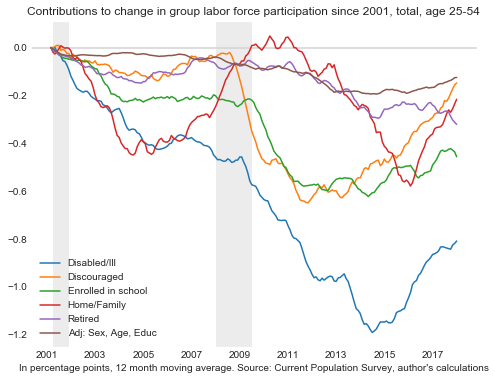

In [6]:
# Calculate age and sex adjusted values
df2 = pd.DataFrame()
df3 = pd.DataFrame()
for year in list(range(2000, 2019)):
    file = f'data/cps_{year}.ft'
    for i, df in pd.read_feather(file, nthreads=3)[ser].groupby('HRMONTH'):
        date = pd.to_datetime(f'{year}-{i}-01')
        d_key_age_sex = f'{year}-{i}_age_sex'
        #d_key_age = f'{year}-{i}_age'
        dft = df[(df['PRTAGE'].between(age[0], age[1])) & 
                 (df['PEMLR'].isin(list(range(1,9)))) & 
                 (df['PESEX'].isin(sex[1]))]
        dft['age_sex'] = dft['PRTAGE'].astype('str') + dft['PESEX'].astype('str')
        age_sex_adj = dft['age_sex'].map(d[d_key_age_sex])
        #age_adj = dft['PRTAGE'].map(d[d_key_age])
        #d_key_sex = f'{year}-{i}_sex'
        #sex_adj = dft['PESEX'].map(d[d_key_sex])
        #d_key_educ = f'{year}-{i}_educ'
        #educ_adj = dft['PEEDUCA'].map(d[d_key_educ])
        wgt = age_sex_adj * dft['PWSSWGT']
        #wgt = (age_adj * sex_adj) * dft['PWSSWGT']  # educ_adj
        gpop = wgt.sum()
        for lf in lfstat[:5]:
            if lf[0] in ['Discouraged', 'Retired', 'Disabled/Ill']:
                gtot = (np.where(dft[lf[2]].isin(lf[1]), 1, 0) * wgt).sum()
                df2.at[date, f'{lf[0]}'] = gtot / gpop * 100
            else:
                gtot = (np.where((dft[lf[2]].isin(lf[1])) & (dft['PEDWWNTO'] == 2), 1, 0) * wgt).sum()
                df2.at[date, f'{lf[0]}'] = gtot / gpop * 100                
        lfpr1 = (np.where(dft['PEMLR'].isin(lfstat[-1][1]), 1, 0) * wgt).sum() / gpop * 100 
        lfpr2 = (np.where(dft['PEMLR'].isin(lfstat[-1][1]), 1, 0) * dft['PWSSWGT']).sum() / dft['PWSSWGT'].sum() * 100
        df2.at[date, 'Adj: Sex & Age'] = lfpr1 - lfpr2 
        df3.at[date, 'LFPR_adj'] = lfpr1
        df3.at[date, 'LFPR_unadj'] = lfpr2
# Plot results
data2 = (df2.rolling(12).mean().loc['2001-03-01'] - df2.rolling(12).mean()).dropna()[3:]
title = (f'Contributions to change in group labor force participation since 2001,'
         f' {sex[0].lower()}, age {age[0]}-{age[1]}')
ax = data2.plot(figsize=(8, 6), title=title)
# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)  
ax = plt.axhline(y=0, color='lightgray', zorder=1)
ax = plt.xlabel("In percentage points, 12 month moving average. Source: Current Population Survey, author's calculations")
#ax = plt.ylim([-2,1])
#ax = plt.legend(loc=3)
plt.savefig(f'{sex[0]}{age[0]}{age[1]}.png', bbox_inches='tight', dpi=200)

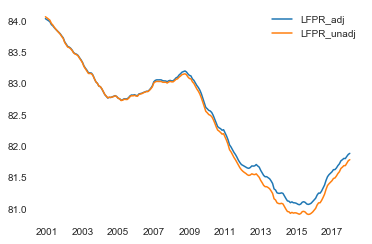

In [7]:
df3.rolling(12).mean().plot()

In [ ]:
# Plot results
data2 = (df2.rolling(12).mean().loc['2001-03-01'] - df2.rolling(12).mean()).dropna()[3:]
title = (f'Contributions to change in group labor force participation since 2001,'
         f' {sex[0].lower()}, age {age[0]}-{age[1]}')
ax = data2.plot(figsize=(8, 6), title=title)
# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)  
ax = plt.axhline(y=0, color='lightgray', zorder=1)
ax = plt.xlabel("In percentage points, 12 month moving average. Source: Current Population Survey, author's calculations")
ax = plt.ylim([-1.5,0.5])
ax = plt.legend(loc=3)
plt.savefig(f'{sex[0]}{age[0]}{age[1]}.png', bbox_inches='tight', dpi=200)

In [ ]:
age_sex_fx = (df2['Age and Sex'].loc['2001-03-01'] - df2['Age and Sex']).loc['2001-03-1':]
data2 = pd.concat([(df2.iloc[:,:-1].rolling(12).mean().loc['2001-03-01'] - df2.iloc[:,:-1].rolling(12).mean()).dropna()[3:], 
           age_sex_fx], axis=1)

In [ ]:
pd.concat([(df2.iloc[:,:-1].rolling(12).mean().loc['2001-03-01'] - df2.iloc[:,:-1].rolling(12).mean()).dropna()[3:], 
           age_sex_fx], axis=1)

In [ ]:
df2.iloc[:,:-1]

In [ ]:
df2

In [ ]:
pd.read_feather('data/cps_2015.ft')

In [ ]:
(df2.rolling(12).mean().loc['2001-01-01'] - df2.rolling(12).mean()).dropna()[1:].plot()

In [ ]:
#dft

In [ ]:
# Create adjusted weight
def weight_gainer(r, data=data):
    return (data[f"{r['PRTAGE']:.0f}{i}{year}"] * r['PWSSWGT'])

# Calculate totals for several activities 
def contrib_calc(year, data, df2, age, sex, ser, lfstat):
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""   
    for i, df in pd.read_feather(f'data/cps_{year}.ft', nthreads=3)[ser].groupby('HRMONTH'):
        print(i)
        date = pd.to_datetime(f'{year}-{i}-01')
        print(date)
        dft = df[(df['PRTAGE'].between(25, 54)) & (df['PEMLR'].isin(range(1,8)))]
        #tpop = dft['PWSSWGT'].sum()
        #for age in list(range(25,55)):#arg in itertools.product(list(range(25, 55)), [('Men', 1), ('Women', 2)]):
        #    gtot = (np.where(dft['PRTAGE']==age, 1, 0) * dft['PWSSWGT']).sum()
        #    data[f'{age}{i}{year}'] = avgage[f'{age}'] - ((gtot / tpop) * 100) + 1
        dft['adjwgt'] = dft.apply(weight_gainer, args=[data], axis=1)
        gpop = dft['adjwgt'].sum()
        for lf in lfstat:
            gtot = (np.where(dft[lf[2]].isin(lf[1]), 1, 0) * dft['adjwgt']).sum()
            df2.at[date, f'{lf[0]}'] = gtot / gpop * 100
    return df2

In [ ]:
# Variables to adjust
ser = ['PWSSWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 
       'PWORWGT', 'PENLFACT', 'PEMLR', 'PEDWWNTO']
lfstat = [('Disabled/Ill', [6], 'PEMLR'),
          ('Discouraged', [1], 'PEDWWNTO'),          
          ('Enrolled in school', [3], 'PENLFACT'),
          ('Home/Family', [4], 'PENLFACT'), 
          ('Retired', [5], 'PEMLR')]#('Unemployed', [3, 4], 'PEMLR')
age = (25, 54)
sex = ('Total', [1, 2])

In [ ]:
# Calculate value for 2000 full year
dft = pd.read_feather('data/cps_2000.ft', nthreads=3)[ser]
avgage = {}
dft = dft[dft['PRTAGE'].between(25, 54)]        
ttot = dft['PWSSWGT'].sum()
for age in list(range(25, 55)):
    gtot = (np.where(dft['PRTAGE']==age, 1, 0) * dft['PWSSWGT']).sum()
    avgage[f'{age}'] = (gtot / ttot) * 100

In [ ]:
data = df#
df2 = pd.DataFrame()
for y in range(2000, 2019):    
    df = contrib_calc(y, data, df2, age, sex, ser, lfstat)

In [ ]:
data2 = (df.rolling(12).mean().loc['2001-03-01'] - df.rolling(12).mean()).dropna()
# Plot change
title = (f'Contributions to change in group labor force participation since 2001,'
         f' {sex[0].lower()}, age {age[0]}-{age[1]}')
ax = data2.drop('Unemployed', axis=1).plot(figsize=(6, 8), title=title)
# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)  
ax = plt.axhline(y=0, color='lightgray', zorder=1)
ax = plt.xlabel("In percentage points, 12 month moving average. Source: Current Population Survey, author's calculations")
plt.savefig(f'{sex[0]}{age[0]}{age[1]}.png', bbox_inches='tight', dpi=200)

In [ ]:
data = df

In [ ]:
pd.read_feather('data/cps_2015.ft', nthreads=2)[ser].groupby('HRMONTH')

In [ ]:
df

In [ ]:
for year in range(1996, 2019):
    for i, df in pd.read_feather(f'data/cps_{year}.ft', nthreads=3)[ser].groupby('HRMONTH'):
        print(i)

In [ ]:
data#.rolling(12).mean().sum(axis=1)#.plot()

In [ ]:
#data.rolling(12).mean().loc['2001-01-01']

data2 = (df.rolling(12).mean().loc['2001-01-01'] - df.rolling(12).mean())#.dropna()

#data2[[f'Women{i}' for i in range(25, 54)]].sum(axis=1).dropna().loc['2001-01-01':].plot()
#(data.rolling(12).mean().loc['2001-01-01'] - data.rolling(12).mean()).dropna()

#data.rolling(12).mean().dropna().sum(axis=1)

In [ ]:
data2.dropna().plot()

In [ ]:
df2
#(df2.rolling(12).mean() - df2.rolling(12).mean().loc['2001-01-01'])

In [ ]:
avg2000 = data.rolling(12).mean().loc['2000-12-01'].to_dict()

In [ ]:
dft = pd.read_feather('data/cps_2000.ft', nthreads=2)[ser]

In [ ]:
avg2

In [ ]:
#pd.read_feather('data/cps_2015.ft', nthreads=3)['']

In [ ]:
for y in range(2000, 2019):
    df = pd.read_pickle(f'data/cps_{year}.pkl')
    gpop = (df[(df['PRTAGE'].between(age[0], age[1])) & 
            (df['PESEX'].isin(sex[1])) & 
            (df['PEMLR'].isin(range(1,8)))].groupby('HRMONTH')['PWSSWGT'].sum())

In [ ]:
data = pd.Series()
for year in range(1996, 2019):
    df = pd.read_pickle(f'data/cps_{year}.pkl')
    group = (df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1]))
    calc = ((df[group & (df['PENLFACT']==3)].groupby('HRMONTH')['PWSSWGT'].sum()) / 
            (df[group & (df['PEMLR'].isin(range(1,8)))].groupby('HRMONTH')['PWSSWGT'].sum())* 100)
    calc.index = [pd.to_datetime(f'{year}-{i}-01') for i in calc.index]
    data = data.append(calc)

In [ ]:
data

In [ ]:
def contrib_calc(year, data):
    df = pd.read_pickle(f'data/cps_{year}.pkl')
    group = (df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1]))
    calc = ((df[group & (df['PENLFACT']==3)].groupby('HRMONTH')['PWSSWGT'].sum()) / 
            (df[group & (df['PEMLR'].isin(range(1,8)))].groupby('HRMONTH')['PWSSWGT'].sum())* 100)
    calc.index = [pd.to_datetime(f'{year}-{i}-01') for i in calc.index]
    data = data.append(calc)

In [ ]:
# Calculate totals for several activities 
def contrib_calc(year, data, age, sex, ser, lfstat):
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000.""" 
    for i, df in pd.read_pickle(f'data/cps_{year}.pkl')[ser].groupby(['HRMONTH']):
        date = pd.to_datetime(f'{year}-{i}-01')
        group = (df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1]))
        gpop = df[group & (df['PEMLR'].isin(range(1,8)))]['PWSSWGT'].sum()
        for lf in lfstat:
            gtot = df[group & (df[lf[2]].isin(lf[1]))]['PWSSWGT'].sum()
            data.at[date, f'{lf[0]}'] = gtot / gpop * 100

In [ ]:
data = pd.Series()
for year in range(2000, 2019):
    contrib_calc(year, data)
data2 = (data.rolling(12).mean().loc['2001-01-01'] - data.rolling(12).mean()).dropna()

# Plot change
title = (f'Contributions to change in group labor force participation since 2001,'
         f' {sex[0].lower()}, age {age[0]}-{age[1]}')
ax = data2.plot(figsize=(10, 4), title=title)
# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)  
ax = plt.axhline(y=0, color='lightgray', zorder=1)
ax = plt.xlabel("In percentage points, 12 month moving average. Source: Current Population Survey, author's calculations")
plt.savefig(f'{sex[0]}{age[0]}{age[1]}.png', bbox_inches='tight', dpi=200)

In [ ]:
group = (df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1]))

In [ ]:
df = pd.read_pickle(f'data/cps_{year}.pkl')[ser]
((df[group & (df['PENLFACT']==3)].groupby('HRMONTH')['PWSSWGT'].sum()) / 
 (df[group & (df['PEMLR'].isin(range(1,8)))].groupby('HRMONTH')['PWSSWGT'].sum())* 100)

In [ ]:
calc = ((df[group & (df['PENLFACT']==3)].groupby('HRMONTH')['PWSSWGT'].sum()) / 
 (df[group & (df['PEMLR'].isin(range(1,8)))].groupby('HRMONTH')['PWSSWGT'].sum())* 100)

In [ ]:
calc.index = [pd.to_datetime(f'{year}-{i}-01') for i in calc.index]

In [ ]:
calc

In [ ]:
year = 2005
for i, df in pickle.load(open(f'data/cps_{year}.pkl', 'rb'))[ser].groupby('HRMONTH'):
    date = pd.to_datetime(f'{year}-{i}-01')
    df = df[(df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1]))]
    gpop = (np.where(df['PEMLR'].isin(range(1,8)), 1, 0) * df['PWSSWGT']).sum()

In [ ]:
df = pd.read_pickle(f'data/cps_2015.pkl')[ser].groupby('HRMONTH')

In [ ]:
df.reset_index().drop('index').to_feather('test.ft')

In [ ]:
df.reset_index(drop=True).to_feather('test.ft')#.drop('index', axis=1)

In [ ]:
df = pd.read_feather('test.ft', nthreads=2)[ser].groupby('HRMONTH')

In [ ]:
df = pd.read_pickle(f'data/cps_{year}.pkl')
((df.loc[(df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1])) & 
        (df['PENLFACT']==3)].groupby('HRMONTH')['PWSSWGT'].sum())/ 
(df.loc[(df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1])) & 
        (df['PEMLR'].isin(range(1,8)))].groupby('HRMONTH')['PWSSWGT'].sum()) * 100)

In [ ]:
(df.loc[(df['PRTAGE'].between(age[0], age[1])) & (df['PESEX'].isin(sex[1])) & 
        (df['PENLFACT']==3)].groupby('HRMONTH')['PWSSWGT'].sum())

In [ ]:
gpop

In [ ]:
data2.drop('Unemployed', axis=1)

In [ ]:
# Plot contribution to change in employment rate since 2001
data2 = pd.DataFrame()
df2 = data.rolling(12).mean().dropna()
for month in list(df2.index):
    for col, val in (df2.loc['2001-01-01'] - df2.loc[month]).items():
        data2.at[month, col] = val
        
# Plot change
title = (f'Contributions to change in group labor force participation since 2001,'
         f' {sex[0][0]} age {ages[0][0]}-{ages[0][1]}')
ax = data2.plot(figsize=(10, 4), title=title)
# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)  
ax = plt.axhline(y=0, color='lightgray', zorder=1)
ax = plt.xlabel("In percentage points, 12 month moving average. Source: Current Population Survey, author's calculations")
plt.savefig(f'{sex[0][0]}{ages[0][0]}{ages[0][1]}.png', bbox_inches='tight', dpi=200)

In [ ]:
gpop

In [ ]:
months = [pd.to_datetime(f'2015-{i}-01') for i in df['HRMONTH'].unique()]

In [ ]:
for arg in itertools.product(df['HRMONTH'].unique(), lfstat):
    df.groupby(arg[0])

In [ ]:
df['HRMONTH'].unique()

In [ ]:
# Calculate totals for several activities 
def contrib_calc(year, data, ages, sex, ser, wc, lfstat):
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""    
    for i, df in pd.read_feather(f'data/cps_{y}.ft', nthreads=3)[ser].groupby('HRMONTH'):
        date = pd.to_datetime(f'{year}-{i}-01')
        for arg in itertools.product(ages, sex):
            dft = df[(df['PRTAGE'].between(arg[0][0], arg[0][1])) & 
                     (df['PESEX'].isin(arg[1][1]))]
            g = np.where(dft['PEMLR'].isin(range(1,8)), 1, 0)
            gpop = (g * dft['PWCMPWGT']).sum() / wc 
            for lf in lfstat:
                vals = np.where(dft[lf[2]].isin(lf[1]), 1, 0)
                gtot = (vals * dft['PWCMPWGT']).sum() / wc
                data.at[date, f'{lf[0]}'] = gtot / gpop * 100
    return data.sort_index()

In [ ]:
# Run the calculator on each year
ages = [(25, 54)]
sex = [('total', [1, 2])]
data = pd.DataFrame()
ser = ['PWSSWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 
       'PWORWGT', 'PENLFACT', 'PEMLR', 'PEDWWNTO']
lfstat = [('Disabled/Ill', [6], 'PEMLR'),
          ('Discouraged', [1], 'PEDWWNTO'),          
          ('Enrolled in school', [3], 'PENLFACT'),
          ('Home/Family', [4], 'PENLFACT'), 
          ('Retired', [5], 'PEMLR')]
wc = 10000000.0   # Monthly weight in thousands of people
for y in range(2000, 2019):    # Test small
    contrib_calc(y, data, ages, sex, ser, wc, lfstat)
    
# Plot contribution to change in employment rate since 2001
data2 = pd.DataFrame()
df2 = data.rolling(12).mean().dropna()
for month in list(df2.index):
    for col, val in (df2.loc['2001-01-01'] - df2.loc[month]).items():
        data2.at[month, col] = val
        
# Plot change
title = (f'Contributions to change in group labor force participation since 2001,'
         f' {sex[0][0]} age {ages[0][0]}-{ages[0][1]}')
ax = data2.plot(figsize=(10, 4), title=title)
# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)  
ax = plt.axhline(y=0, color='lightgray', zorder=1)
ax = plt.xlabel("In percentage points, 12 month moving average. Source: Current Population Survey, author's calculations")
plt.savefig(f'{sex[0][0]}{ages[0][0]}{ages[0][1]}.png', bbox_inches='tight', dpi=200)

In [ ]:
pd.read_pickle(f'data/cps_{y}.pkl')

In [ ]:
# Plot contribution to change in employment rate since 2001
data2 = pd.DataFrame()
df2 = data.rolling(12).mean().dropna()
for month in list(df2.index):
    for col, val in (df2.loc['2001-01-01'] - df2.loc[month]).items():
        data2.at[month, col] = val
        
# Plot change
ax = data2.plot(figsize=(10, 4), title='Contribution to change in employment-rate since 2001, women age 25-54')
ax = plt.axhline(y=0, color='lightgray')
plt.savefig('women2554.png', bbox_inches='tight', dpi=200)

In [ ]:
# Calculate totals for several activities 
def contrib_calc(year, data, ages, sex, ser, wc, lfstat):
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""    
    raw = pd.read_pickle(f'data/cps_{y}.pkl')[ser]
    grouped = raw.groupby('HRMONTH')
    for i, df in grouped:
        date = pd.to_datetime(f'{year}-{i}-01')
        for arg in itertools.product(ages, sex):
            group = f'{arg[1][0]}, {arg[0][0]}-{arg[0][1]} years old'
            dft = df[(df['PRTAGE'].between(arg[0][0], arg[0][1])) & 
                     (df['PESEX'].isin(arg[1][1]))]
            g = np.where(dft['PEMLR'].isin(range(1,8)), 1, 0)
            gpop = (g * dft['PWCMPWGT']).sum() / wc 
            for lf in lfstat:
                vals = np.where(dft[lf[2]].isin(lf[1]), 1, 0)
                if lf[0] in ['Disc2', 'Disc3']:
                    gpop = (g * dft['PWORWGT']).sum() / wc
                    gtot = (vals * dft['PWORWGT']).sum() / wc
                else:
                    gtot = (vals * dft['PWCMPWGT']).sum() / wc
                col_name = (f'{lf[0]} {group}')
                #data.at[date, f'{col_name}, in thousands'] = gtot
                data.at[date, f'{col_name}, share'] = gtot / gpop * 100
    return data.sort_index()

In [ ]:
# Run the calculator on each year
ages = [(25, 54)] # (25, 34), (35, 44), (45, 54), (55, 64), 
sex = [('total', [1, 2])] # ('men', [1]), ('women', [2]), 
data = pd.DataFrame()
ser = ['PWCMPWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 
       'PWORWGT', 'PENLFACT', 'PEMLR', 'PEDWWNTO']
lfstat = [#('Unemployed', [2], 'PREMPNOT'), 
          #('Employed', [1], 'PREMPNOT'), 
          #('Labor Force', range(1,5), 'PEMLR'),
          #('Disabled/Ill', [1, 2], 'PENLFACT'),
          ('Disabled/Ill', [6], 'PEMLR'),
          #('Discouraged', [3], 'PREMPNOT'),
          #('Disc2', [1, 2], 'PRDISC'),
          ('Discouraged', [1], 'PEDWWNTO'),          
          #('NILF-other', [4], 'PREMPNOT'), 
          ('School', [3], 'PENLFACT'),
          ('Care', [4], 'PENLFACT'), 
          #('retired1', [5], 'PENLFACT'), 
          #('retired-older', [1], 'PENLFRET'),
          ('retired3', [5], 'PEMLR')]#,
          #('NILF-oth-act', [6], 'PENLFACT')]
wc = 10000000.0   # Monthly weight in thousands of people
for y in range(1998, 2019):    # Test small
    data = contrib_calc(y, data, ages, sex, ser, wc, lfstat)

In [ ]:
data.head()

In [ ]:
data2 = pd.DataFrame()
df2 = data.rolling(12).mean().dropna()
for month in list(df2.index):
    for col, val in (df2.loc['2001-01-01'] - df2.loc[month]).items():
        data2.at[month, col] = val
        
%matplotlib inline
data2.iloc[:,-5:].plot()

In [ ]:
for month in list(df2.index):
    for col, val in (df2.loc['2001-01-01'] - df2.loc[month]).items():
        data2.at[month, col] = val

In [ ]:
#data2.loc['2001-01-01':].rolling(12).mean().dropna()
#val = data2.loc['2001-01-01':] - data.loc['2018-01-01']
data2.to_csv('test7.csv')

In [ ]:
%matplotlib inline
data2.iloc[:,-5:].plot()

In [ ]:
for col, val in data.loc[month] - data.loc['2001-01-01']:
    print(col)

In [ ]:
df2 = data.rolling(12).mean().dropna()
#val = data.loc['2018-01-01'] - data.loc['2001-01-01']

In [ ]:
for x, y in val.items():
    print(x)

In [ ]:
df2.loc['2018-01-01'] - df2.loc['2000-01-01']

In [ ]:
pd.read_pickle('data/cps_1998.pkl')

In [ ]:
# Calculate totals for several activities 
def contrib_calc(year, data, ages, sex, ser, wc):
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""    
    raw = pd.read_pickle(f'data/cps_{y}.pkl')[ser]
    grouped = raw.groupby('HRMONTH')
    for i, df in grouped:
        date = pd.to_datetime(f'{year}-{i}-01')
        for arg in itertools.product(ages, sex):
            dft = df[(df['PRTAGE'].between(arg[0][0], arg[0][1])) & 
                     (df['PESEX'] == arg[1][1])]
            il = np.where(dft['PENLFACT'].isin([1, 2]), 1, 0)
            sc = np.where(dft['PENLFACT'].isin([3]), 1, 0)
            ca = np.where(dft['PENLFACT'].isin([4]), 1, 0)
            rt1 = np.where(dft['PENLFACT'].isin([5]), 1, 0)
            rt = np.where(dft['PENLFRET'].isin([1]), 1, 0)
            un = np.where(dft['PREMPNOT'].isin([2]), 1, 0)
            em = np.where(dft['PREMPNOT'].isin([1]), 1, 0)
            di = np.where(dft['PREMPNOT'].isin([3]), 1, 0)
            ot = np.where(dft['PREMPNOT'].isin([4]), 1, 0)
            ot2 = np.where(dft['PENLFACT'].isin([6]), 1, 0)
            lfstat = [('Unemployed', un), ('Employed', em), ('Disabled/Ill', il),
                      ('Discouraged', di), ("NILF - other", ot), ('School', sc),
                      ('Care', ca), ('retired1', rt1), ('retired-older', rt),
                      ('NILF-oth-act', ot2)]
            for item, vals in lfstat:
                col_name = (f'{item} {arg[1][0]}, {arg[0][0]}-'
                            f'{arg[0][1]} years old, in thousands')
                data.at[date, col_name] = (vals * dft['PWCMPWGT']).sum() / wc
    return data.sort_index()

In [ ]:
lfstat = [('Unemployed', [2], 'PREMPNOT'), 
          ('Employed', [1], 'PREMPNOT'), 
          ('Disabled/Ill', [1, 2], 'PENLFACT'),
          ('Discouraged', [3], 'PREMPNOT'), 
          ('NILF-other', [4], 'PREMPNOT'), 
          ('School', [3], 'PENLFACT'),
          ('Care', [4], 'PENLFACT'), 
          ('retired1', [5], 'PENLFACT'), 
          ('retired-older', [1], 'PENLFRET'),
          ('NILF-oth-act', [6], 'PENLFACT')]

In [ ]:
def group_total(dft, lf, arg, wc):
    vals = np.where(dft[lf[2]].isin(lf[1]), 1, 0)
    col_name = (f'{lf[0]} {arg[1][0]}, {arg[0][0]}-'
                f'{arg[0][1]} years old, in thousands')
    return (vals * dft['PWCMPWGT']).sum() / wc

In [ ]:
def lf_stat_calc(data, dft, lf, arg, wc):
    vals = np.where(dft['PENLFACT'].isin([1, 2]), 1, 0)
    col_name = (f'{lf[0]} {arg[1][0]}, {arg[0][0]}-'
                f'{arg[0][1]} years old, in thousands')
    data.at[date, col_name] = (val * dft['PWCMPWGT']).sum() / wc
    return data

In [ ]:
# Run the calculator on each year
ages = [(25, 34), (35, 44), (45, 54)]
sex = [('men', 1), ('women', 2)]
data = pd.DataFrame()
ser = ['PREMPNOT', 'PWCMPWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 'PENLFACT', 'PENLFRET', 'PRERNWA']
wc = 10000000.0   # Monthly weight in thousands of people
for y in range(1998, 2019):    # Test small
    data = contrib_calc(y, data, ages, sex, ser, wc)

In [ ]:
raw_contr = 

In [ ]:
df.groupby('PRTAGE')['PRERNWA'].describe()

In [ ]:
df

In [ ]:
data.loc['2000-01-01']

In [ ]:
def contrib_calc(year, data, ages, sex):
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""    
    ser = ['PREMPNOT', 'PWCMPWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 'PENLFACT', 'PENLFRET']
    wc = 10000000.0   # Monthly weight in thousands of people
    raw = pd.read_pickle(f'data/cps_{y}.pkl')[ser]
    grouped = raw.groupby(['HRMONTH', 'PESEX'])
    for i, df in grouped:
        date = pd.to_datetime(f'{year}-{i}-01')
        for arg in itertools.product(ages, sex):
            dft = df[(df['PRTAGE'].between(arg[0][0], arg[0][1])) & 
                     (df['PESEX'] == arg[1][1])]
            il = np.where(dft['PENLFACT'].isin([1, 2]), 1, 0)
            sc = np.where(dft['PENLFACT'].isin([3]), 1, 0)
            ca = np.where(dft['PENLFACT'].isin([4]), 1, 0)
            rt1 = np.where(dft['PENLFACT'].isin([5]), 1, 0)
            rt = np.where(dft['PENLFRET'].isin([1]), 1, 0)
            un = np.where(dft['PREMPNOT'].isin([2]), 1, 0)
            em = np.where(dft['PREMPNOT'].isin([1]), 1, 0)
            di = np.where(dft['PREMPNOT'].isin([3]), 1, 0)
            ot = np.where(dft['PREMPNOT'].isin([4]), 1, 0)
            ot2 = np.where(dft['PENLFACT'].isin([6]), 1, 0)
            lfstat = [('Unemployed', un), ('Employed', em), ('Disabled/Ill', il),
                      ('Discouraged', di), ("NILF - other", ot), ('School', sc),
                      ('Care', ca), ('retired1', rt1), ('retired-older', rt),
                      ('NILF-oth-act', ot2)]
            for item, vals in lfstat:
                col_name = (f'{item} {arg[1][0]}, {arg[0][0]}-'
                            f'{arg[0][1]} years old, in thousands')
                data.at[date, col_name] = (vals * dft['PWCMPWGT']).sum() / wc
    return data.sort_index()

In [ ]:
data = pd.DataFrame()
ages = [(25, 34), (35, 44), (45, 54)]
sex = {1: 'men', 2: 'women'}
#sex = [('men', 1), ('women', 2)]
ser = ['PREMPNOT', 'PWCMPWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 'PENLFACT', 'PENLFRET']
wc = 10000000.0   # Monthly weight in thousands of people
raw = pd.read_pickle('data/cps_2017.pkl')[ser]
grouped = raw.groupby(['HRMONTH', 'PESEX'])
for i, df in grouped:
    date = pd.to_datetime(f'2017-{i[0]}-01')
    for age in ages:
        dft = df[(df['PRTAGE'].between(age[0], age[1]))]
        il = np.where(dft['PENLFACT'].isin([1, 2]), 1, 0)
        sc = np.where(dft['PENLFACT'].isin([3]), 1, 0)
        ca = np.where(dft['PENLFACT'].isin([4]), 1, 0)
        rt1 = np.where(dft['PENLFACT'].isin([5]), 1, 0)
        rt = np.where(dft['PENLFRET'].isin([1]), 1, 0)
        un = np.where(dft['PREMPNOT'].isin([2]), 1, 0)
        em = np.where(dft['PREMPNOT'].isin([1]), 1, 0)
        di = np.where(dft['PREMPNOT'].isin([3]), 1, 0)
        ot = np.where(dft['PREMPNOT'].isin([4]), 1, 0)
        ot2 = np.where(dft['PENLFACT'].isin([6]), 1, 0)
        lfstat = [('Unemployed', un), ('Employed', em), ('Disabled/Ill', il),
                  ('Discouraged', di), ("NILF - other", ot), ('School', sc),
                  ('Care', ca), ('retired1', rt1), ('retired-older', rt),
                  ('NILF-oth-act', ot2)]
        for item, vals in lfstat:
            col_name = (f'{item} {sex[i[1]]}, {age[0]}-{age[1]} years old, in thousands')
            data.at[date, col_name] = (vals * dft['PWCMPWGT']).sum() / wc

In [ ]:
data

In [ ]:
grouped = df.groupby(['HRMONTH', 'PESEX'])

In [ ]:
for x, y in grouped:
    print(x)

In [ ]:
def contrib_calc():
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""
    data = pd.DataFrame()
    ages = [(25, 34), (35, 44), (45, 54)]
    sex = [('men', 1), ('women', 2)]
    ser = ['PREMPNOT', 'PWCMPWGT', 'HRMONTH', 'PRTAGE', 'PESEX', 'PENLFACT', 'PENLFRET']
    wc = 10000000.0   # Monthly weight in thousands of people
    for y in range(1998, 2019):    # Test small
        df = pd.read_pickle(f'data/cps_{y}.pkl')[ser]
        mos = list(df['HRMONTH'].unique())
        for arg in itertools.product(mos, ages, sex):
            dft = df[(df['HRMONTH'] == arg[0]) & 
                     (df['PRTAGE'].between(arg[1][0], arg[1][1])) & 
                     (df['PESEX'] == arg[2][1])]
            il = np.where(dft['PENLFACT'].isin([1, 2]), 1, 0)
            sc = np.where(dft['PENLFACT'].isin([3]), 1, 0)
            ca = np.where(dft['PENLFACT'].isin([4]), 1, 0)
            rt1 = np.where(dft['PENLFACT'].isin([5]), 1, 0)
            rt = np.where(dft['PENLFRET'].isin([1]), 1, 0)
            un = np.where(dft['PREMPNOT'].isin([2]), 1, 0)
            em = np.where(dft['PREMPNOT'].isin([1]), 1, 0)
            di = np.where(dft['PREMPNOT'].isin([3]), 1, 0)
            ot = np.where(dft['PREMPNOT'].isin([4]), 1, 0)
            ot2 = np.where(dft['PENLFACT'].isin([6]), 1, 0)
            date = pd.to_datetime(f'{y}-{arg[0]}-01')
            lfstat = [('Unemployed', un), ('Employed', em), ('Disabled/Ill', il),
                      ('Discouraged', di), ("NILF - other", ot), ('School', sc),
                      ('Care', ca), ('retired1', rt1), ('retired-older', rt),
                      ('NILF-oth-act', ot2)]
            for item, vals in lfstat:
                col_name = (f'{item} {arg[2][0]}, {arg[1][0]}-'
                        f'{arg[1][1]} years old, in thousands')
                data.at[date, col_name] = (vals * dft['PWCMPWGT']).sum() / wc
    return data.sort_index()

In [ ]:
df = contrib_calc()

In [ ]:
data

In [ ]:
def contrib_calc():
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""
    data = pd.DataFrame()
    vars_vals = [('PREMPNOT', [2])]
    ages = [(25, 34), (35, 44), (45, 54)]
    sex = [('men', 1), ('women', 2)]
    for y in range(1998, 2019):    # Test small
        df = pd.read_pickle(f'data/cps_{y}.pkl')
        mos = list(df['HRMONTH'].unique())
        for arg in itertools.product(vars_vals, ages, sex):
            col_name = (f'Unemployed {arg[2][0]}, {arg[1][0]}-'
                        f'{arg[1][1]} years old, in thousands')
            dft = df[(df['PRTAGE'].between(arg[1][0], arg[1][1])) & 
                     (df['PESEX'] == arg[2][1])]
            r = np.where(dft[arg[0][0]].isin(arg[0][1]), 1, 0)
            #date = pd.to_datetime(f'{y}-{arg[0]}-01')
            #data.at[date, col_name] = (r * dft['PWCMPWGT']).sum()
    return #data.sort_index()

In [ ]:
d = pd.read_pickle('data/cps_2017.pkl')
for month in range (1, 13):
    df = d[d['HRMONTH'] == month]
    un = np.where(df['PREMPNOT'].isin([2]), 1, 0)
    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
    unrt = ((un * df['PWCMPWGT']).sum() / (lf * df['PWCMPWGT']).sum())
    print(f"Month {month}: {unrt * 100:.1f}%")

In [ ]:
un = np.where(df['PREMPNOT'].isin([2]), 1, 0)
lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)

In [ ]:
(un * df['PWCMPWGT']).sum() / (lf * df['PWCMPWGT']).sum()

In [ ]:
def contrib_calc():
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""
    data = pd.DataFrame()
    vars_vals = [('PREMPNOT', [1, 2, 3, 4])]
    ages = [(25, 34), (35, 44), (45, 54)]
    sex = [('men', 1), ('women', 2)]
    ser = 'PREMPNOT, PWCMPWGT, HRMONTH, PRTAGE, PESEX'
    wc = 10000000.0   # Monthly weight in thousands of people
    for y in range(1998, 2019):    # Test small
        df = pd.read_pickle(f'data/cps_{y}.pkl')
        mos = list(df['HRMONTH'].unique())
        for arg in itertools.product(mos, vars_vals, ages, sex):
            col_name = (f'Unemployed {arg[3][0]}, {arg[2][0]}-'
                        f'{arg[2][1]} years old, in thousands')
            dft = df[(df['HRMONTH'] == arg[0]) & 
                     (df['PRTAGE'].between(arg[2][0], arg[2][1])) & 
                     (df['PESEX'] == arg[3][1])]
            r = np.where(dft[arg[1][0]].isin(arg[1][1]), 1, 0)
            date = pd.to_datetime(f'{y}-{arg[0]}-01')
            data.at[date, col_name] = (r * dft['PWCMPWGT']).sum() / wc
    return data.sort_index()

In [ ]:
def contrib_calc(filters, measure='lfpr'):
    """Calculate NILF categories' contribution to group change 
       in labor force measures (lfpr, epop) since 2000."""
    data = pd.DataFrame()
    ser = 'PREMPNOT, PWCMPWGT, HRMONTH'   # Need to add the rest
    for y in range(1998, 2019):    # Test small
        ex = f"select {ser} from cps_{y} {filters}"
        df = pd.read_sql(ex, conn)
        wgt = df['PWCMPWGT']
        wc = float(max(df['HRMONTH'].unique()) * 10000000)
        vars_vals = [('PREMPNOT', [2])]
        for var, val in vars_vals:
            r = (np.where(df[var].isin(val), 1, 0) * wgt).sum()
            data.at[y, var] = r / wc
    return data

In [ ]:
ser = 'PREMPNOT, PWCMPWGT, HRMONTH, PRTAGE, PESEX'
filters = "where (PRTAGE between 25 and 54) and (HRMONTH = 1)"
ex = f"select * from cps_2012 {filters}"
df = pd.read_sql(ex, conn)

In [ ]:
len(df)

In [ ]:
len(df.drop_duplicates())

In [ ]:
mos = list(df['HRMONTH'].unique())
vars_vals = [('PREMPNOT', [2])]
ages = [(25, 34), (35, 44), (45, 54)]
sex = [('men', 1), ('women', 2)]

In [ ]:
data = pd.DataFrame()
for arg in itertools.product(mos, vars_vals, ages, sex):
    col_name = (f'Unemployed {arg[3][0]},'
               f'{arg[2][0]}-{arg[2][1]} years old')
    dft = df[(df['HRMONTH'] == arg[0]) & 
             (df['PRTAGE'].between(arg[2][0], arg[2][1])) & 
             (df['PESEX'] == arg[3][1])]
    r = np.where(dft[arg[1][0]].isin(arg[1][1]), 1, 0)
    date = pd.to_datetime(f'{y}-{arg[0]-01}')
    data.at[date, col_name] = (r * dft['PWCMPWGT']).sum()

In [ ]:
data

In [ ]:
data = contrib_calc()
data

In [ ]:
%matplotlib inline
data.plot(legend=False)

In [ ]:
data.iloc[167:]